<a href="https://colab.research.google.com/github/twizz0328/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 41 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (10.3 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 121713 files and direc

- 런타임 -> 세션 다시 시작

In [1]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [2]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)

        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)
                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')

                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

In [3]:
df

,image
0,https://glltn.com/wp-content/blogs.dir/1/files...
1,https://glltn.com/wp-content/blogs.dir/1/files...
2,https://glltn.com/wp-content/blogs.dir/1/files...
3,https://glltn.com/wp-content/blogs.dir/1/files...
4,https://glltn.com/wp-content/blogs.dir/1/files...
5,https://glltn.com/wp-content/blogs.dir/1/files...
6,https://glltn.com/wp-content/blogs.dir/1/files...
7,https://glltn.com/wp-content/blogs.dir/1/files...
8,https://glltn.com/wp-content/blogs.dir/1/files...
9,https://glltn.com/wp-content/blogs.dir/1/files...


## 14-2 수집 데이터 확인

In [4]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM(Vision Language Model) 모델 로드

In [5]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [6]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

preprocessor_config.json:   0%|          | 0.00/714 [00:00<?, ?B/s]

processing_minicpmv.py: 0.00B [00:00, ?B/s]

image_processing_minicpmv.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- processing_minicpmv.py
- image_processing_minicpmv.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=

1


In [7]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [8]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book titled "why dogs are better than cats" with an image of a cat on the cover, resting its head on a dog's back. To the right side of the frame is a real-life cat, standing and observing the camera, which has a similar striped pattern as the one depicted on the book cover. The setting appears to be indoors, possibly on a wooden surface or floor.


## 14-5 의류 이미지 여부 판단

In [9]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image is of clothing. It features a green hoodie with the word "ARM" printed on it, layered over a blue denim shirt and paired with jeans. The focus on the garment's design elements such as the color contrast, the text, and the fit suggests that the purpose of the photograph may be to showcase the clothing item for fashion or retail purposes.
Yes, this image is of clothing. It showcases a person wearing what appears to be a layered outfit consisting of a heavy-duty jacket and a knitted scarf or collar, which are common elements in fashion photography that focus on apparel. The composition and presentation suggest it could be from a fashion catalog or editorial piece where the emphasis is on the style and design of the clothes rather than the individual's identity.
Yes, this image is of clothing. It showcases a person wearing a textured brown coat and matching accessories that are likely designed for cold weather. The focus on the attire suggests it may be used for fashion or 

## 14-6 의류 판단 결과 시각화

In [10]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,False
4,,True
5,,True
6,,False
7,,True
8,,False
9,,False


## 14-7 의류 이미지 필터링

In [11]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

In [12]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
4,,True
5,,True
7,,True
10,,True
11,,True


## 14-8 의류 스타일 분석

In [13]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-1874085826.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [14]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes in the image reflects a casual, streetwear aesthetic that is popular for its comfort and relaxed fit. The green hoodie with the ""ARM"" logo is a classic piece that has been reimagined with a modern twist through the use of bold lettering on the chest area. This kind of graphic branding is a common feature in contemporary streetwear fashion, which often incorporates logos and text as part of its design.\n\nThe layered look, combining a hooded sweatshirt over a collared shirt, suggests an intentional approach to styling where functionality meets fashion. Layering is a trend that allows for versatility in clothing choices, catering to both warmth and style. The denim jeans are a staple in casual wear, known for their durability and timeless appeal. The faded wash and distressed details add a vintage touch, which is another element embraced by many streetwear trends.\n\nOverall, the colors—green, blue, and grey—are subdued yet distinct enough to stand out while still being versatile enough to be paired with various other items in a wardrobe. These elements together create a look that is both trendy and comfortable, indicative of current fashion trends that favor practicality without sacrificing style."
1,,True,"The style of the clothes in the image suggests a contemporary, possibly avant-garde approach to fashion. The color palette is monochromatic and muted, which is often associated with minimalist or Scandinavian design trends that favor simplicity and functionality over bold colors. This choice can also evoke a sense of timelessness, making the clothing appear versatile across seasons.\n\nThe oversized jacket with its structured pockets and belt detail adds an element of ruggedness and practicality, hinting at influences from military or utilitarian fashion. Such designs are popular in streetwear and casual fashion for their relaxed fit and durable appearance.\n\nThe combination of layers, including the visible knit garment under the coat, indicates a trend towards layering as a key aspect of modern wardrobe construction. Layering allows for adaptability to changing temperatures and provides a dynamic visual interest through contrast in textures and fabrics.\n\nOverall, the outfit reflects a blend of comfort, utility, and modern aesthetics, likely appealing to those who appreciate understated elegance and functional fashion statements."
2,,True,"The style of the clothes in the image leans towards a cozy, winter aesthetic. The teddy bear coat is indicative of a trend that favors textured, plush fabrics for warmth and comfort during colder seasons. Such coats are often associated with a relaxed, casual look, which has become increasingly popular as fashion trends have shifted towards more laid-back and comfortable styles. The color choice of brown adds to this sense of earthiness and simplicity, suggesting an appeal to natural tones that are versatile and seasonally appropriate.\n\nThe matching beanie and scarf not only provide additional warmth but also create a coordinated ensemble that emphasizes the overall theme of coziness and uniformity. This kind of styling is practical for cold weather while also being visually cohesive and stylish.\n\nIn terms of color trends, darker hues like the one worn here are timeless and tend to stay fashionable across different seasons. They offer a neutral base that can easily match with other colors or patterns, making them a staple in many wardrobes. The lack of bright colors suggests a preference for understated elegance over bold statements, which aligns with current trends favoring minimalism and subtlety in design.\n\nOverall, the clothing choices reflect a contemporary approach to winter fashion, focusing on comfort, functionality, and a harmonious blend of textures and colors."
4,,True,"The style of the clothes in the image leans towards a minimalist and modern aesthetic, often associated with contemporary fashion trends. The 

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [15]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

INFO 11-26 19:28:33 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 11-26 19:28:34 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 11-26 19:28:58 config.py:549] This model supports multiple tasks: {'score', 'classify', 'embed', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 11-26 19:28:58 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 11-26 19:29:01 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 11-26 19:29:01 cuda.py:226] Using XFormers backend.
INFO 11-26 19:29:02 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 11-26 19:29:02 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 11-26 19:31:31 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 148.404421 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 11-26 19:32:18 model_runner.py:1115] Loading model weights took 4.5146 GB
INFO 11-26 19:32:21 worker.py:267] Memory profiling takes 2.51 seconds
INFO 11-26 19:32:21 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 11-26 19:32:21 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 11-26 19:32:21 executor_base.py:111] # cuda blocks: 1625, # CPU blocks: 3495
INFO 11-26 19:32:21 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 11-26 19:32:26 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:46<00:00,  1.34s/it]

INFO 11-26 19:33:13 model_runner.py:1562] Graph capturing finished in 47 secs, took 0.21 GiB
INFO 11-26 19:33:13 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 55.73 seconds


## 14-10 색상 정보 추출

In [16]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주세요.\n{style}"
          # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

INFO 11-26 19:36:29 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s, est. speed input: 355.02 toks/s, output: 9.44 toks/s]


색상: 녹색, 파란색, 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.17it/s, est. speed input: 565.54 toks/s, output: 34.80 toks/s]


**색상:**
- **회색** (monochromatic palette)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s, est. speed input: 1391.03 toks/s, output: 26.33 toks/s]


**색상:** 갈색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  5.27it/s, est. speed input: 1653.93 toks/s, output: 21.20 toks/s]


색상: 회색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s, est. speed input: 711.36 toks/s, output: 32.33 toks/s]


갈색 (brown)
검정색 (black)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s, est. speed input: 986.66 toks/s, output: 28.81 toks/s]


- beige
- light khaki


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.94it/s, est. speed input: 1033.85 toks/s, output: 27.73 toks/s]


색상: 갈색, 검정색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s, est. speed input: 876.96 toks/s, output: 31.95 toks/s]

**색상:**
- 올리브 그린



/tmp/ipython-input-4205533662.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [17]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_style(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요.\n{style}"
          # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_style)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.64s/it, est. speed input: 184.47 toks/s, output: 38.96 toks/s]


- 캐주얼
- 스트리트웨어
- 편안함
- 유연한 핏
- 고전적 디자인
- 현대적 터치
- 그래픽 브랜딩
- 레이어드 스타일
- 기능성과 패션의 조화
- 다목적성
- 내구성
- 빈티지 터치
- subdued 색상
- 다양성


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 111.46 toks/s, output: 40.42 toks/s]


- **현대적**
- **미니멀리즘**
- **스칸디나비아**
- **심플**
- **기능성**
- **타임리스**
- **강인함**
- **실용성**
- **스트리트웨어**
- **레이어링**
- **적응성**
- **동적**
- **내구성**
- **세련됨**
- **기능적**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it, est. speed input: 250.91 toks/s, output: 38.54 toks/s]


- coziness
- textured
- plush fabrics
- relaxed
- casual
- earthiness
- simplicity
- versatility
- warmth
- uniformity
- practicality
- timelessness
- neutral base
- minimalism


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, est. speed input: 189.37 toks/s, output: 39.80 toks/s]


- **미니멀리즘**
- **현대적**
- **유니버셜**
- **타임리스**
- **편안함**
- **아방가르드**
- **심플**
- **믹스앤매치**
- **유연성**
- **미니멀리즘**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.51s/it, est. speed input: 175.78 toks/s, output: 39.65 toks/s]


- **실용성**
- **패션**
- **도시적**
- **따뜻함**
- **보호**
- **기능성**
- **전통적**
- **럭셔리**
- **세련됨**
- **혼합 스타일**


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it, est. speed input: 110.68 toks/s, output: 40.50 toks/s]


- **미니멀리즘**
- **현대적**
- **중립색**
- **단순컷**
- **베이지**
- **라이트카키**
- **카드igan**
- **무채색**
- **지구색**
- **시간대**
- **세련됨**
- **편안함**
- **세부사항**
- **레이어드**
- **실용성**
- **다양성**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.43s/it, est. speed input: 184.03 toks/s, output: 39.19 toks/s]


- 클래식
- timeless
- 중성색 (갈색, 검정색)
- sophistication
- 다양성
- 고급스러움
- 텍스처
- 전통적 디자인과 현대적 기능성의 조화
- 실용성
- 내구성
- 유지보수 용이성


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.66s/it, est. speed input: 150.34 toks/s, output: 40.45 toks/s]

- utilitarian
- military-inspired
- practicality
- durability
- vintage
- retro
- rugged appeal
- versatility
- oversized fit
- pocket flaps
- reinforced seams
- comfort
- functionality
- workwear
- relaxed sophistication
- streetwear
- functional accessories
- historical influences



/tmp/ipython-input-4075720662.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_style)


In [18]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the clothes in the image reflects a casual, streetwear aesthetic that is popular for its comfort and relaxed fit. The green hoodie with the ""ARM"" logo is a classic piece that has been reimagined with a modern twist through the use of bold lettering on the chest area. This kind of graphic branding is a common feature in contemporary streetwear fashion, which often incorporates logos and text as part of its design.\n\nThe layered look, combining a hooded sweatshirt over a collared shirt, suggests an intentional approach to styling where functionality meets fashion. Layering is a trend that allows for versatility in clothing choices, catering to both warmth and style. The denim jeans are a staple in casual wear, known for their durability and timeless appeal. The faded wash and distressed details add a vintage touch, which is another element embraced by many streetwear trends.\n\nOverall, the colors—green, blue, and grey—are subdued yet distinct enough to stand out while still being versatile enough to be paired with various other items in a wardrobe. These elements together create a look that is both trendy and comfortable, indicative of current fashion trends that favor practicality without sacrificing style.","색상: 녹색, 파란색, 회색",- 캐주얼\n- 스트리트웨어\n- 편안함\n- 유연한 핏\n- 고전적 디자인\n- 현대적 터치\n- 그래픽 브랜딩\n- 레이어드 스타일\n- 기능성과 패션의 조화\n- 다목적성\n- 내구성\n- 빈티지 터치\n- subdued 색상\n- 다양성
1,,True,"The style of the clothes in the image suggests a contemporary, possibly avant-garde approach to fashion. The color palette is monochromatic and muted, which is often associated with minimalist or Scandinavian design trends that favor simplicity and functionality over bold colors. This choice can also evoke a sense of timelessness, making the clothing appear versatile across seasons.\n\nThe oversized jacket with its structured pockets and belt detail adds an element of ruggedness and practicality, hinting at influences from military or utilitarian fashion. Such designs are popular in streetwear and casual fashion for their relaxed fit and durable appearance.\n\nThe combination of layers, including the visible knit garment under the coat, indicates a trend towards layering as a key aspect of modern wardrobe construction. Layering allows for adaptability to changing temperatures and provides a dynamic visual interest through contrast in textures and fabrics.\n\nOverall, the outfit reflects a blend of comfort, utility, and modern aesthetics, likely appealing to those who appreciate understated elegance and functional fashion statements.",**색상:**\n- **회색** (monochromatic palette),- **현대적**\n- **미니멀리즘**\n- **스칸디나비아**\n- **심플**\n- **기능성**\n- **타임리스**\n- **강인함**\n- **실용성**\n- **스트리트웨어**\n- **레이어링**\n- **적응성**\n- **동적**\n- **내구성**\n- **세련됨**\n- **기능적**
2,,True,"The style of the clothes in the image leans towards a cozy, winter aesthetic. The teddy bear coat is indicative of a trend that favors textured, plush fabrics for warmth and comfort during colder seasons. Such coats are often associated with a relaxed, casual look, which has become increasingly popular as fashion trends have shifted towards more laid-back and comfortable styles. The color choice of brown adds to this sense of earthiness and simplicity, suggesting an appeal to natural tones that are versatile and seasonally appropriate.\n\nThe matching beanie and scarf not only provide additional warmth but also create a coordinated ensemble that emphasizes the overall theme of coziness and uniformity. This kind of styling is practical for cold weather while also being visually cohesive and stylish.\n\nIn terms of color trends, darker hues like the one worn here are timeless and tend to stay fashionable across different seasons. They offer a neutral base that can easily match with other colors or patterns, making them a staple in many wardrobes. The lack of bright colors suggests a preference for understated elegance over bold statements, which aligns 

## 14-12 텍스트 데이터 정제

In [19]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

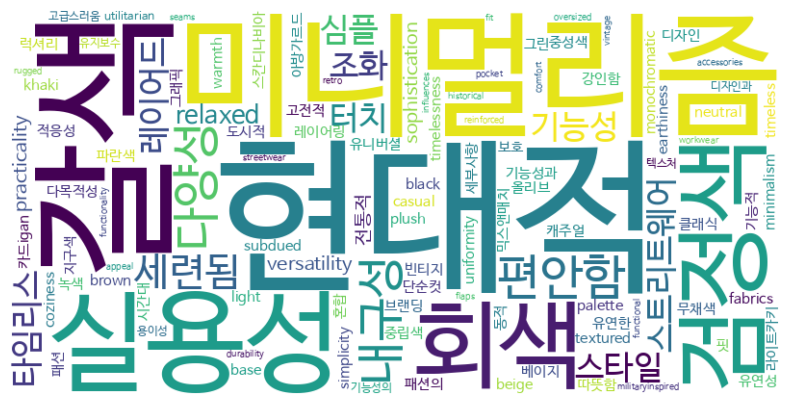

In [20]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [21]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노트: {row.style}\n이미지 url:{row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일 노트를 토대로 종합적인 트렌드 방향 분석 보고서를 작성해주세요. 보고서 제목은 해외 룩북 스타일입니다. 내용은 전문적이면서 명확하게 설명해주세요. 문서 형식은 markdown으로 만들어주세요."})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:22<00:00, 22.79s/it, est. speed input: 107.11 toks/s, output: 38.74 toks/s]


In [22]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 트렌드 분석 보고서

## 개요
본 보고서는 최근 여러 해외 패션 룩북에서 관찰되는 주요 스타일 트렌드를 종합적으로 분석하고, 그 특징과 미래 전망을 제시합니다. 다양한 컬렉션에서 포착된 패턴과 요소들을 통해 현대 패션의 방향성을 파악하고자 합니다.

## 트렌드 분석

### 1. **실용성과 스타일의 융합**
- **특징**: 
  - **편안함과 기능성의 결합**: 스트리트웨어와 캐주얼 패션에서 편안함과 실용성이 강조됨. 예를 들어, **오가닉 소재의 후드티**와 **층층이 겹쳐진 코트**는 일상적인 활동성과 스타일리시함을 동시에 제공합니다.
  - **기능적 디자인**: **군사적 요소를 차용한 재킷**과 **수디 소재의 부츠**는 내구성과 현대적 감각을 결합한 사례로, **실용성과 패션의 융합**을 보여줍니다.
  
- **예시**:
  - **John Bull Fall Winter 2025 컬렉션**: **오가닉 후드티와 distressed jeans**로 편안함과 빈티지한 느낌을 결합.
  - **URU Fall Winter 2025 컬렉션**: **오버사이즈 재킷과 beanie**로 실용성과 캐주얼한 스타일을 동시에 표현.
  - **Nepenthes Fall Winter 2025 컬렉션**: **베이지색 코트와 beanie**로 따뜻함과 세련됨을 동시에 제공.
  - **Graphpaper Spring Summer 2026 컬렉션**: **오버사이즈 블레이저와 니트**로 편안함과 현대적인 감각을 결합.
  - **Nonnative Diemme Explorer Lace-Up Boots**: **군사적 디자인 요소를 활용한 부츠**로 실용성과 패션성을 동시에 강조.

### 2. **색상과 텍스처의 조화**
- **특징**:
  - **중립 색상의 활용**: **베이지, 브라운, 그레이** 등 중립 색상은 계절을 초월한 활용성과 세련됨을 제공합니다. 이는 **다양한 스타일링 가능성**을 높입니다.
  - **텍스처의 다양성**: **수디, 가죽, distressed wash** 등 다양한 텍스처의 활용으로 시각적 흥미와 감각적 경험을 풍부하게 합니다.

- **예시**:
  - **Graphpaper 컬렉션**: **중립 색상의 코트와 니트**로 계절에 상관없이 착용 가능한 스타일을 제시.
  - **Nonnative 컬렉션**: **군사적 디자인의 부츠와 수디 소재의 재킷**으로 텍스처의 대조를 통해 독특한 룩을 구현.

### 3. **미니멀리즘과 기능성의 결합**
- **특징**:
  - **간결한 디자인**: **단순한 패턴과 깔끔한 라인**이 강조되며, 이는 **현대적이고 세련된 이미지**를 창출합니다.
  - **필수적인 액세서리**: **기능적인 아이템**이 패션의 일부로 자리잡아, **스타일의 완성도를 높입니다**.

- **예시**:
  - **Filmelange 컬렉션**: **심플한 컬러 팔레트와 카드igan**으로 미니멀한 스타일을 구현.
  - **Warobe 컬렉션**: **군사적 요소를 활용한 재킷과 가방**으로 실용성과 패션성을 동시에 강조.

## 결론
현대 패션 트렌드는 **실용성과 스타일의 균형**, **중립적이고 다양한 색상의 활용**, 그리고 **미니멀리즘과 기능성의 융합**을 중심으로 발전하고 있습니다. 이러한 경향은 소비자들이 일상 생활에서 편안함과 동시에 세련된 이미지를 추구하는 경향을 반영하며, 앞으로도 이러한 요소들이 지속적으로 패션 디자인에 영향을 미칠 것으로 예상됩니다.

---

이 보고서는 다양한 패션 컬렉션에서 관찰된 패턴을 바탕으로 작성되었으며, 미래 트렌드 예측에 있어 중요한 지표를 제공합니다.